<a href="https://colab.research.google.com/github/AliEbadi110/Computer-Vision-Image-Classification-Sample-Projects/blob/main/Computer_Vision_PyTorch_Image_Classification_AlexNet_Cats_vs_Dogs_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision - PyTorch - Image Classification - AlexNet- Cats vs Dogs - Transfer Learning**

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp '/content/drive/MyDrive/Colab Datasets/kaggle.json' ~/.kaggle

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

100% 217M/218M [00:06<00:00, 36.2MB/s]
100% 218M/218M [00:06<00:00, 36.3MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [ ]:
!mkdir '/content/CatsDogs'
!mv '/content/training_set/training_set' '/content/CatsDogs'
!mv '/content/test_set/test_set' '/content/CatsDogs'

In [ ]:
path = '/content/CatsDogs'
img_names = []

for folder, subfolders, filenames in os.walk(path):
  for img in filenames:
    img_names.append(folder+'/'+img)

In [ ]:
len(img_names)

10032

In [ ]:
img_sizes = []
rejected = []

for item in img_names:
  try:
    with Image.open(item) as img:
      img_sizes.append(img.size)
  except:
    rejected.append(item)

In [ ]:
print(len(img_sizes))
print(len(rejected))

10028
4


In [ ]:
for i in rejected:
  os.remove(i)

In [ ]:
transformer_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [ ]:
transformer_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [ ]:
train_dataset = datasets.ImageFolder(
    root='/content/CatsDogs/training_set',
    transform=transformer_train)

In [ ]:
test_dataset = datasets.ImageFolder(
    root='/content/CatsDogs/test_set',
    transform=transformer_test)

In [ ]:
class_names = train_dataset.classes
class_names

['cats', 'dogs']

In [ ]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

## 3. Data Overview

In [ ]:
df = pd.DataFrame(img_sizes, columns=['width', 'height'])
df.head()

,width,height
0,320,239
1,360,269
2,431,279
3,150,149
4,400,362


In [ ]:
df.describe()

,width,height
count,10028.000000,10028.000000
mean,403.997108,360.507379
std,108.753655,96.945867
min,57.000000,33.000000
25%,322.000000,300.000000
50%,446.500000,374.000000
75%,499.000000,422.000000
max,1050.000000,768.000000


In [ ]:
print(f'Number of samples in training dataset: {len(train_dataset)}')
print(f"Number of cats in training dataset: {len(os.listdir('/content/CatsDogs/training_set/cats'))}")
print(f"Number of dogs in training dataset: {len(os.listdir('/content/CatsDogs/training_set/dogs'))}")

Number of samples in training dataset: 8005
Number of cats in training dataset: 4000
Number of dogs in training dataset: 4005


In [ ]:
print(f'Number of samples in test dataset: {len(test_dataset)}')
print(f"Number of cats in test dataset: {len(os.listdir('/content/CatsDogs/test_set/cats'))}")
print(f"Number of dogs in test dataset: {len(os.listdir('/content/CatsDogs/test_set/dogs'))}")

Number of samples in test dataset: 2023
Number of cats in test dataset: 1011
Number of dogs in test dataset: 1012


In [ ]:
for images, labels in train_loader:
  break

In [ ]:
images.shape

torch.Size([16, 3, 224, 224])

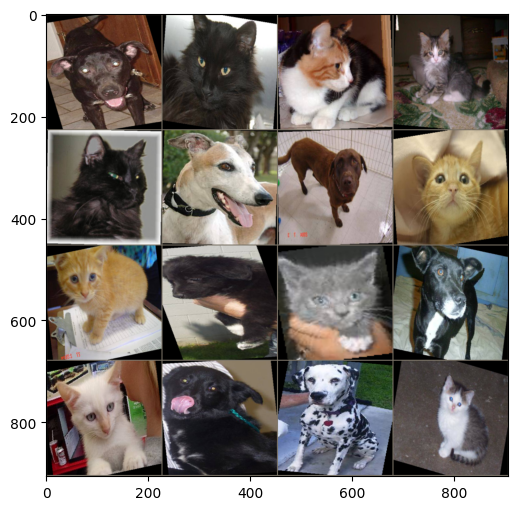

In [ ]:
im = make_grid(images, nrow=4)
inv_normalize = transforms.Normalize(
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

## 4. Build Model

In [ ]:
anmodel = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 185MB/s]


In [ ]:
anmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in anmodel.parameters():
  param.requires_grad = False

In [ ]:
anmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(1024, 2),
                                   nn.LogSoftmax(dim=1))

In [ ]:
anmodel.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [ ]:
summary(anmodel, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(anmodel.classifier.parameters())

## 5. Train Model

In [ ]:
n_epochs = 1
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for i in range(n_epochs):

  anmodel.train()
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs_train = anmodel(inputs)
    loss_train = criterion(outputs_train, targets)

    loss_train.backward()
    optimizer.step()

    train_loss.append(loss_train.item())

  train_loss = np.mean(train_loss)


  anmodel.eval()
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs_train = anmodel(inputs)
    loss_test = criterion(outputs_train, targets)

    test_loss.append(loss_test.item())

  test_loss = np.mean(test_loss)

  train_losses[i] = train_loss
  test_losses[i] = test_loss

  print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/1, Train Loss: 0.4165, Test Loss: 0.1151


## 6. Predict, Evaluate

> **Classification**

In [ ]:
anmodel.eval()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = anmodel(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

In [ ]:
y_test = np.array(test_dataset.targets)

In [ ]:
print(classification_report(p_test, y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      1048
         1.0       0.93      0.97      0.95       975

    accuracy                           0.95      2023
   macro avg       0.95      0.95      0.95      2023
weighted avg       0.95      0.95      0.95      2023



In [ ]:
print(confusion_matrix(p_test, y_test))

[[982  66]
 [ 29 946]]


In [ ]:
labels = '''cats
dogs
'''.split('\n')

Text(0.5, 1.0, 'True label: dogs   Predicted: cats')

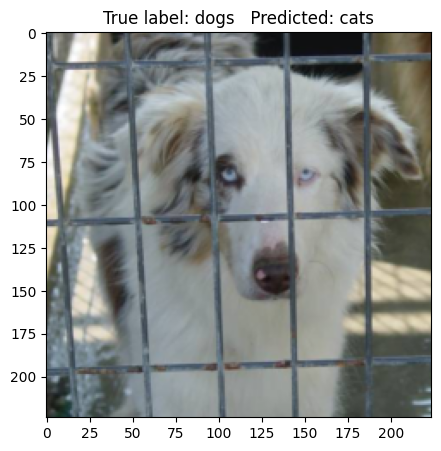

In [ ]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
fig = plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(inv_normalize(test_dataset[i][0]), (1, 2, 0)))
plt.title(f'True label: {labels[y_test[i]]}   Predicted: {labels[p_test[i]]}')